<center><b><font size=6>Machine Learning for Networking <b><center>
<center><b><font size=6>Lab 10 <b><center>
<center><b><font size=6>   Neural networks <b><center>

## LAB objective: define and train neural network models using Pytorch

**Pytorch** is one of the most popular Python library for deep learning tasks and it is highly configurable. In this lab, you will learn how to define a feedforward neural network for supervised problems.

Useful link: <a href="https://pytorch.org/docs/stable/index.html">documentation</a>, <a href="https://pytorch.org/tutorials/beginner/basics/intro.html">basics</a>, <a href="https://pytorch.org/tutorials/beginner/pytorch_with_examples.html">examples</a>.

In [1]:
# To install pytorch. Then restart kernel. 
# WARNING: it takes around 5 minutes

!python -m pip install torch
!python -m pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 11.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 30.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 26.6 MB/s eta 0:00:0000:0100:01


In [2]:
# import needed python libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms

## 1. Tutorial - Neural networks for classifying hand-written digits
We will use the MNIST dataset, which is a well-known image dataset for studying neural networks.
It contains 70000 images (28x28 greyscale) of hand-written digit numbers from 0 to 9, and you need to define and train a neural network hypothesis to classify the image to the corresponding number.

In [3]:
# load data and split into train, validation and test
# the snippet here is customized for MNIST dataset, you don't have to know how it works exactly

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean and stardard deviation, already computed for MNIST dataset
])

dataset = MNIST('data/train', train=True, download=True, transform=transform)
dataset_test = MNIST('data/test', train=False, download=True, transform=transform)

# Further split intro training and validation set
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(len(dataset)*5/6), int(len(dataset)/6)])

len(dataset_train), len(dataset_val), len(dataset_test)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/train/MNIST/raw/train-images-idx3-ubyte.gz to data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw



(50000, 10000, 10000)

 We can visualize a random sample of the dataset. Run the cell multiple times to see different samples.

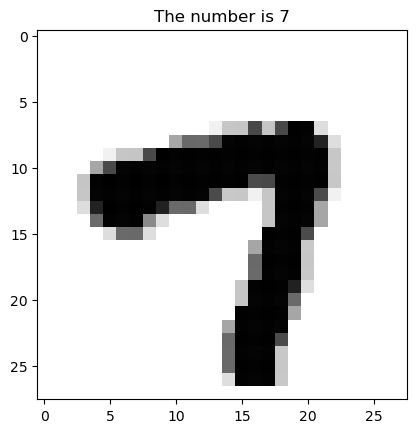

In [4]:
plt.figure()
n = random.randint(0, len(dataset_train)) #a random index
image = dataset_train[n][0] # this is a 1x28x28 image. We represent it as grayscale (it is not RGB image)
label = dataset_train[n][1]
plt.imshow(image[0, :], cmap='Greys') 
plt.title(f'The number is {label}')
plt.show()

In [5]:
image.shape

torch.Size([1, 28, 28])

 We define a function to compute accuracy and plot confusion matrix. We will use them multiple times later.

In [6]:
# define the function that calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # .item() to convert a tensor into a primitive type (float or int).
    acc = (correct / len(y_pred))
    return acc

# function to compute and plot the confusion matrix
def confusion_matrix(y_true, y_pred):
    df = pd.DataFrame([x for x in zip([x.item() for x in y_true], [x.item() for x in y_pred])], columns=['y_true', 'y_pred'])
    df[['samples']] = 1
    confusion = pd.pivot_table(df, index='y_true', columns='y_pred', values='samples', aggfunc=sum)
    plt.figure()
    sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True')    
    plt.title('Confusion matrix')
    plt.show()

 Transform data into tensors and generate features and labels for train, validation and test.

In [7]:
#transform data into tensor X and tensor y
def get_data_label(dataset):
    # Initialize lists to store training data and labels
    data = []
    labels = []
    
    # Iterate through the dataset to extract data and labels
    for datum, label in dataset:
        data.append(datum)
        labels.append(torch.tensor([label]))
    
    # Concatenate the data and labels lists into tensors
    data = torch.cat(data, dim=0)
    labels = torch.cat(labels)
    
    return data, labels

In [8]:
# We extract all data and labels from the datasets. It may take a while.
X_train, y_train = get_data_label(dataset_train)
print(f"Training set length: {X_train.shape[0]}")

X_val, y_val = get_data_label(dataset_val)
print(f"Validation set length: {X_val.shape[0]}")

X_test, y_test = get_data_label(dataset_test)
print(f"Test set length: {X_test.shape[0]}")

Training set length: 50000
Validation set length: 10000
Test set length: 10000


 The model architecture we are defining is a feed-forward neural network. It takes the input, feeds it through two hidden layers one after the other, and then finally gives the output. The input layer has many neurons as the pixels of the images, i.e., 28x28=784 neurons. The first hidden layer has 784 neurons and uses a tanh activation function. The second layer has 392 neurons and uses a tanh activation function. The output layer has 10 neurons, with softmax activation function.

![](basic_NN.png)

#### A typical training procedure for a neural network is as follows:
1. Define the neural network, the loss function and the optimizer
2. Iterate over a dataset of training inputs (training epochs)
3. Forward step: process input through the network
4. Compute the loss (empirical risk) 
5. Backward step (backpropagation): Compute and propagate gradients back into the network’s parameters
6. Update the weights of the network, typically using a variation of gradient descent step: $weight = weight - learning \ rate \times gradient$

In [9]:
# Define the neural network in the picture

class Model_classification(nn.Module): # a class that inherits from the module of pytorch neural network 
    def __init__(
        self, 
        in_features, # number of input features
        out_features, # number of output features
        hidden_1, # number of neurons in the 1st hidden layer
        hidden_2 # number of neurons in the 2nd hidden layer
    ):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=in_features, out_features=hidden_1) # 1st linear layer
        self.layer_2 = nn.Linear(in_features=hidden_1, out_features=hidden_2) # 2nd linear layer
        self.layer_output = nn.Linear(in_features=hidden_2, out_features=out_features) # output layer
        self.activation_1 = nn.Tanh() # activation function
        self.activation_2 = nn.Softmax() # activation function

    # define feedforward process
    def forward(self, x):
        x = x.flatten(start_dim=1) #to go from 28x28 image tensor to 784 input tensor
        out = self.activation_1(self.layer_1(x)) #output of 1st hidden layer
        out = self.activation_1(self.layer_2(out)) #output of 2nd hidden layer
        out = self.activation_2(self.layer_output(out)) #output of the nn (a logit!)
        return out

- For loss function, we are going to use the cross entropy loss
- For optimizer, the ADAM optimizer (a variant of classic gradient descent  https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)

In [10]:
# set a random seed 
torch.manual_seed(8)

# initialize the model with the correspoding hyper-parameters
dim_features = len(X_train[0].flatten()) #784 = 28 x 28
model = Model_classification(
    in_features = dim_features, 
    out_features = 10, 
    hidden_1 = dim_features, 
    hidden_2 = int(dim_features / 2)
)

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the optimizer (pass the parameters (model) that you want to optimize, and the learning rate)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3) 

Let's train the network for 10 epochs and keep track of the loss and accuracy on the training and validation after each epoch.

**Note** : if you run the following cell multiple times, the weights will not be re-initialized. Hence, you will continue the previous training each time. If you want to re-initialize the weights, re-define the model (i.e., run the previous cell)

In [11]:
# training process

loss_train_all = []
loss_val_all = []
acc_train_all = []
acc_val_all = []
epochs = 10

# Iterate over a dataset of inputs (training epochs)
for epoch in range(epochs):

    # model training phase
    model.train() #initialize training phase 
    y_prob = model(X_train).squeeze() #  Process input through the network. Get the output probability of predictions. We are using all the data and not in batches
    loss = loss_fn(y_prob, y_train) # calculate the empirical risk (average of the losses) 
    optimizer.zero_grad() # reset the gradients of model parameters
    loss.backward() # backpropagate the empirical risk (prediction loss)
    optimizer.step() # adjust the parameters by the gradients 

    # model evaluation phase
    model.eval() #initialize evaluation phase 
    
    # get metrics for the training set
    y_prob = model(X_train).squeeze() #  Process input through the network. Get the output probability of predictions. We are using all the data and not in batches
    y_pred = torch.argmax(y_prob, dim=1) # get the label --> multiclass, select the max of the softmax output
    acc_train = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # get metrics for the validation set
    y_prob = model(X_val).squeeze() 
    loss_val = loss_fn(y_prob, y_val) 
    y_pred = torch.argmax(y_prob, dim=1)
    acc_val = accuracy_fn(y_true=y_val, y_pred=y_pred)

    # collect results
    loss_train_all.append(loss.item())
    loss_val_all.append(loss_val.item())
    acc_train_all.append(acc_train)
    acc_val_all.append(acc_val)
    
    print(f'Epoch: {epoch} | Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}') 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | Train Loss: 2.30375, Val Loss: 2.20252, Train Acc: 0.62, Val Acc: 0.62
Epoch: 1 | Train Loss: 2.20121, Val Loss: 2.07935, Train Acc: 0.59, Val Acc: 0.59
Epoch: 2 | Train Loss: 2.07637, Val Loss: 1.97059, Train Acc: 0.66, Val Acc: 0.66
Epoch: 3 | Train Loss: 1.96721, Val Loss: 1.87972, Train Acc: 0.74, Val Acc: 0.73
Epoch: 4 | Train Loss: 1.87697, Val Loss: 1.81711, Train Acc: 0.77, Val Acc: 0.77
Epoch: 5 | Train Loss: 1.81461, Val Loss: 1.77416, Train Acc: 0.79, Val Acc: 0.78
Epoch: 6 | Train Loss: 1.77160, Val Loss: 1.73506, Train Acc: 0.81, Val Acc: 0.81
Epoch: 7 | Train Loss: 1.73256, Val Loss: 1.70512, Train Acc: 0.83, Val Acc: 0.83
Epoch: 8 | Train Loss: 1.70285, Val Loss: 1.68139, Train Acc: 0.84, Val Acc: 0.84
Epoch: 9 | Train Loss: 1.67948, Val Loss: 1.66074, Train Acc: 0.86, Val Acc: 0.86


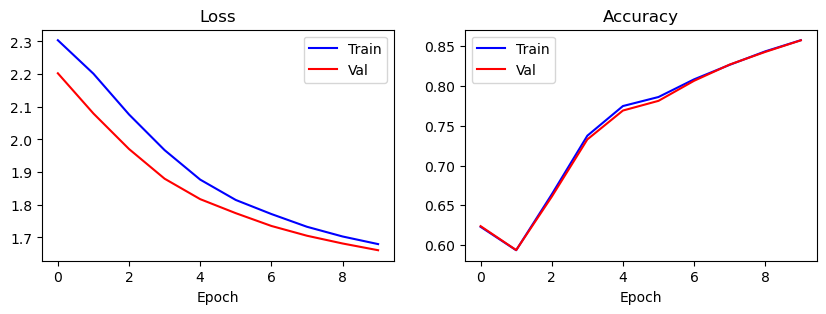

In [12]:
# visualize the evolution of losses and accuracies

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))

ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(loss_train_all, label='Train', color='blue')
ax1.plot(loss_val_all, label='Val', color='red')
ax1.legend()

ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.plot(acc_train_all, label='Train', color='blue')
ax2.plot(acc_val_all, label='Val', color='red')
ax2.legend()

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The final validation accuracy is: 0.8575


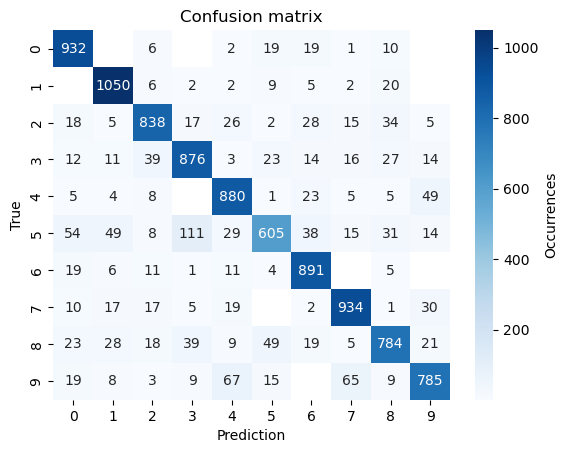

In [13]:
# visualize (final) confusion matrix on validation set
y_prob = model(X_val).squeeze() 
y_pred = torch.argmax(y_prob, dim=1)
acc_val = accuracy_fn(y_true=y_val, y_pred=y_pred)
print('The final validation accuracy is:', acc_val)
confusion_matrix(y_val, y_pred)

#### Now you can try to repeat the process by changing some of the hyper-parameters of the neural network:
- number of layers
- number of neurons per layer
- activation functions

#### And some of the hyper-parameters of the training procedure:
- number of epochs
- learning rate
- version of the optimizer            

Finally, apply the chosen hypothesis on test data and measure the performance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The test accuracy is: 0.8691


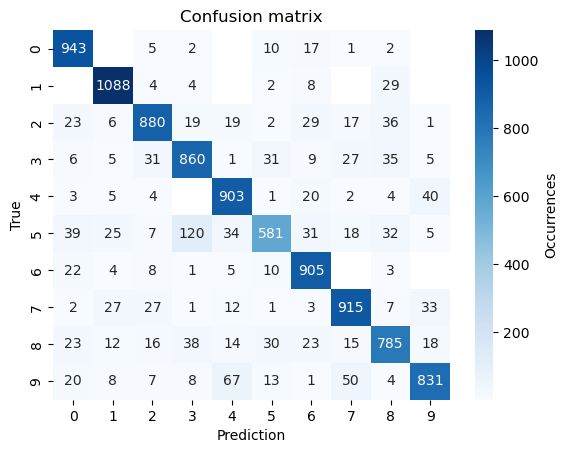

In [14]:
#Apply the model to test dataset

model.eval()
y_prob = model(X_test).squeeze()
y_pred = torch.argmax(y_prob, dim=1)
acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
print('The test accuracy is:', acc)
confusion_matrix(y_test, y_pred)

Let's see some examples of samples with their prediction

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


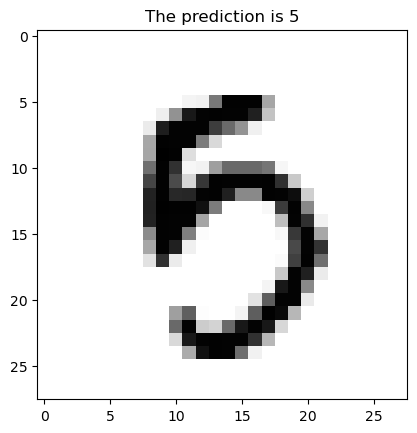

In [21]:
plt.figure()
model.eval()
n = random.randint(0, len(dataset_test))
image = X_train[:1] # the model always expect a batch of data to pass
label = y_train[0]
y_prob = model(image).squeeze()
y_pred = torch.argmax(y_prob)
plt.imshow(image.squeeze(), cmap='Greys') 
plt.title(f'The prediction is {y_pred}')
plt.show()

Now let's see an example of misclassified sample

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


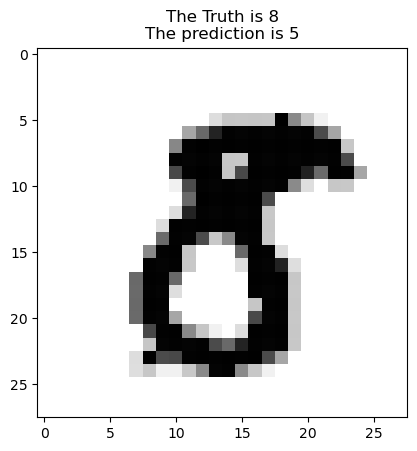

In [22]:
for n in range(len(dataset_test)):
    model.eval()
    image = X_train[n:n+1]
    y_prob = model(image).squeeze()
    y_pred = torch.argmax(y_prob)
    true = y_train[n]
    if y_pred != true:
        plt.figure()
        plt.imshow(image.squeeze(), cmap='Greys')
        plt.title(f'The Truth is {true}\nThe prediction is {y_pred}')
        plt.show()
        break

### Deal with numpy data

For MNIST, pytorch handled the data transformation automatically, which is often not the case in reality. **Importantly, pytorch only works with torch tensor.** Therefore, for pandas or numpy data, the first thing you need to do after data preprocessing and before feeding the data to the torch model is to convert your data into tensors!

In [23]:
# a 5x3 matrix (numpy multidimensional ndarray)
x = np.random.rand(5, 3)
x

array([[0.82181849, 0.1138505 , 0.66117427],
       [0.8072867 , 0.46306425, 0.38370618],
       [0.63039594, 0.68960531, 0.20462308],
       [0.86462015, 0.41895737, 0.37810801],
       [0.83837026, 0.04200546, 0.96713316]])

In [24]:
#transforming the numpy multidimensional ndarray into a pytorch tensor
x_t = torch.tensor(x, dtype=torch.float, requires_grad=False) # Is True if gradients need to be computed for this Tensor, for input data is normally False
print(x_t)

print(x_t.numpy())

tensor([[0.8218, 0.1139, 0.6612],
        [0.8073, 0.4631, 0.3837],
        [0.6304, 0.6896, 0.2046],
        [0.8646, 0.4190, 0.3781],
        [0.8384, 0.0420, 0.9671]])
[[0.8218185  0.1138505  0.6611743 ]
 [0.8072867  0.46306425 0.38370618]
 [0.63039595 0.6896053  0.20462307]
 [0.86462015 0.41895738 0.37810802]
 [0.83837026 0.04200546 0.96713316]]


### Some remarks
1. For almost every function that you need to implement, like data loading, accuracy computation, batches and early stopping, you can find an implementation in pytorch or other libraries. In this lab, you can try to explore them on your own or implement the functions from scratch. 
2. It is easy to make errors regarding the dimension of tensors. Hint: use ``.shape`` to check out the shape of a tensor, and then check again the shape after performing certain operations.

## 2. Exercise - Neural networks for classifying service of TCP flow logs

The dataset 'log_tcp_complete_classes.txt' contains traffic information generated by an open-source passive network monitoring tool called **tstat**. It automates the collection of packet statistics of traffic aggregates, using real-time monitoring features. Being a passive tool, the typical usage scenario is live monitoring of Internet links, in which all transmitted packets are observed.

In case of TCP, Tstat identifies a new flow start when it observes a TCP three-way handshake. Similarly, it identifies a TCP flow end either when it sees the TCP connection teardown, or when it doesn’t observe packets for some time (idle time). 
A flow is defined by a unique link between the sender and receiver, e.g., a tuple of <em>(IP_Protocol_Type, IP_Source_Address, Source_Port, IP_Destination_Address, Destination_Port)</em>. For a specific flow, tstat calculates a number of statistics of all the packets transmitted over this flow, and then generates a log for such flow with multiple attributes (statistics). 

A log file is arranged as a simple table where each column is associated to specific information and each row reports the flow during a connection. The log information is a summary of the flow properties. For instance, in the TCP log we can find columns like the starting time of a TCP connection, its duration, the number of sent and received packets, the observed Round Trip Time.

In this exercise, you need to predict the service the client connected to in each flow, given the features of the TCP connection. The ``class:207`` is our label, and contains 10 different services, such as ``amazon`` and ``google``


In [ ]:
df = pd.read_csv("log_tcp_complete_classes.txt", sep=" ")
df

### 2.1 Dataset pre-processing

1. In the dataset, there are some categorical features (columns): ``#31#c_ip:1, c_port:2, s_ip:15, s_port:16, con_t:42, p2p_t:43, http_t:44, p2p_st:59, http_res:113, c_tls_SNI:116, s_tls_SCN:117, c_npnalpn:118, s_npnalpn:119, fqdn:127, dns_rslv:128``, in which ``#31#c_ip:1, c_port:2, s_ip:15, s_port:16, c_tls_SNI:116, s_tls_SCN:117, fqdn:127`` are required to be dropped.
2. The column ``class:207`` is our label and it is also a categorical one, and you need to convert it to numerical labels to represent different connections. You can refer to:
```python
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(...)
```
3. Perform a stratified segmentation to split the dataset into training, validation, and test sets, with a portion of 1%, 9%, and 90%. We are choosing a very small portion for training set to make the training faster for this exercise. In general, it is not a good idea to use just 1% of samples for training.
4. For the rest of categorical features (columns) that remain in the dataset, you need to use one-hot encoding to convert the categories, by using ``OneHotEncoder`` to replace the original categorical features to one-hot features. Specifically, the function will compute the number of distinct categories, and then generate as many 0/1 variables (columns) as there are different categories. For example, if a feature has 3 distinct values, you will end up with 3 columns with 0 and 1 in the form of (0,0,1), (0,1,0), and (1,0,0), in which each tuple represents one of the original categories. Specifically:
    - You can record the numerical index of the remaining categorical columns in the original dataframe
    - After performing data segmentation, you end up with numpy arrays. Since you know which columns represent categorical features according to the previous step, you can first generate one-hot features of training set and then delete original categorical features, combining remaining numerical features and one-hot features: 
```python
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore') # specify that you ignore possible unseen categories
enc.fit(X_train[:, idx_columns_categorical_needed])
features_enc_train = enc.transform(X_train[:, idx_columns_categorical_needed]).toarray()
... = np.delete(...)
... = np.concatenate([..., ...])
```
    - The ```OneHotEncoder``` needs to be fitted on training set, and then transform validation and test set. For each dataset, you need to remove the original categorical features.
5. Standardize the dataset as always, fitting the scalar on training set and then trasforming the entire dataset.
6. Convert your data to tensors.

In [ ]:
### Step 1
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columns_categorical = [
    '#31#c_ip:1', 'c_port:2', 's_ip:15', 's_port:16', 'con_t:42',
    'p2p_t:43', 'http_t:44', 'p2p_st:59', 'http_res:113', 'c_tls_SNI:116',
    's_tls_SCN:117', 'c_npnalpn:118', 's_npnalpn:119', 'fqdn:127', 'dns_rslv:128'
]

columns_drop = ["#31#c_ip:1", "c_port:2", "s_ip:15", "s_port:16", "c_tls_SNI:116", "s_tls_SCN:117", "fqdn:127"]

df.drop(columns=columns_drop, inplace=True)


In [ ]:
### Step 2
### Your answer here


In [ ]:
### Step 3
### Your answer here

In [ ]:
### Step 4
### Your answer here

In [ ]:
### Step 5
### Your answer here

In [ ]:
### Step 6
### Your answer here

### 2.2 Define the neural network model, the loss function and the optimizer

Develop your model with an architecture that you think is proper, e.g., two hidden layers with number of neurons equivalent to the number of features. Specifically:
- Build you model class and then initialize your model
- Define activation function for each layer (e.g., tanh for hidden layers and softmax for output layer) 
- Define the optimizer with learning rate (e.g., Adam with learning rate 0.001)

In [ ]:
### Your answer here
### ...

### 2.3 Build your basic training loop
Build you training loop that is similar to the tutorial, specifically:
- Set the number of epochs to be 50 (this may take a while during the training)
- Build you training loop including training phase and validation phase
- At each epoch, record the losses and accuracies for training and validation sets. Print the current losses and accuracies for training and validation sets

In [ ]:
### Your answer here
### ...

### 2.4 Evaluate your model
1. Plot the evolution of losses and accuracies for training and validation set.
2. Print the accuracy and plot confusion matrix of the final hypothesis on validation set. 

In [ ]:
### Your answer here
### ...

### 2.5 Advanced training
1. Change the previous training loop, implementing/using two important mechanisms:
    - Data batch: At each epoch, split the training dataset into batches (e.g., 64 samples) and train the model on each batch sequentially. At each trial of training (for each batch), calculate the loss, and the final loss of the entire training set is calculated (at the end of this epoch), averaging the losses of all batches. You can realize batch training on your own or rely on functions provided by pytorch, like ``DataLoader`` (<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">documentation</a>).
    - Early stopping: Set the training epochs to infinite, and implement your own early stopping, terminating the training loop when the accuracy on validation is not improving anymore. Again, you can build your own early-stopping mechanism, or learn the function provided by pytorch (<a href="https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html">documentation</a>).

Remeber to re-initialize the model and re-define the optimizer.

2. Evaluate the model:
    - Plot the evolution of losses and accuracies for training and validation set, and indicate the epoch where the model stopped.
    - Print the accuracy and plot confusion matrix of the final hypothesis on validation set. 
    - Answer the following questions:
        - At how many epochs the early stopping stops the training? Is it very different from the previous one? If yes, why?
        - At the same number of epochs, Which training procedure generates better performance (with or without data batch) ?  Why?

In [ ]:
### Your answer here
### ...

### 2.6 Evaluate final hypothesis on test set
 
Use the best hypotesis on test set: derive the final performance by outputing accuracy and confusion matrix. 

In [ ]:
### Your answer here
### ...